<div style="background-color:#1e1e1e; padding:25px; border-radius:10px; display:table; width:100%;">

  <!-- Left column: text -->
  <div style="display:table-cell; vertical-align:top; width:80%; padding-right:10px;">
    <h1 style="color:#4FC3F7; margin-bottom:10px;">Hands-On Part A: Loading a Pretrained Model</h1>

  <p style="font-size:18px; font-style:italic; color:#cccccc;">
    Workshop on T1D Simulator and Digital Twins for Personalized Care
  </p>

  <p style="font-size:15px; line-height:1.6; color:#dddddd;">
    This preparatory notebook demonstrates how to load a pretrained deep learning model
    for type 1 diabetes (T1D) simulation, inspect its structure, and process patient data
    using physiological approximations. We will use the data we process here for Part B.
  </p>
  </div>

  <!-- Right column: logo -->
  <div style="display:table-cell; vertical-align:middle; text-align:right; width:20%; padding-right:80px;">
    <img src="https://micelab.udg.edu/wp-content/uploads/2022/08/MICElab-letras_png-300x119.png" alt="MiceLab Logo" style="height:80px; border-radius:8px;">
  </div>

</div>


<h2 style="color:#4FC3F7; border-bottom:2px solid #4FC3F7; padding-bottom:4px;">
0. Imports &amp; Set-Up
</h2>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/t1d-data-based-digital-twin/scripts')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install netron tqdm

In [18]:
from pathlib import Path

import matplotlib.pyplot as plt
import netron
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from tqdm import tqdm
from google.colab import output
from IPython.display import IFrame

import tensorflow as tf
from tensorflow.keras.utils import plot_model


<h2 style="color:#4FC3F7; border-bottom:2px solid #4FC3F7; padding-bottom:4px;">
1. Load Model
</h2>

Setup path and model name.

In [ ]:
path_to_model = "/content/drive/MyDrive/Colab Notebooks/t1d-data-based-digital-twin/misc"
model_name = "pretrained-model.h5"

Load the .h5 using the `load_model` method from keras.

In [6]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model

class CompatibleLSTM(LSTM):
    def __init__(self, *args, **kwargs):
        kwargs.pop("time_major", None)
        super().__init__(*args, **kwargs)

custom = {"LSTM": CompatibleLSTM}

In [8]:
model_filename = Path(path_to_model, model_name)
pretrained_vae_model = tf.keras.models.load_model(model_filename, custom_objects=custom, compile=False)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


<h2 style="color:#4FC3F7; border-bottom:2px solid #4FC3F7; padding-bottom:4px;">
2. Inspect Model
</h2>

Let's explore the structure of the model we just loaded.

<h3 style="color:#4FC3F7; border-bottom:2px solid #4FC3F7; padding-bottom:4px;">
2.1 Text summary
</h3>
The `.summary()` method is usually the first step when inspecting a model, it shows in plain text each Layer's
- Name and type
- Output Shape (first element is always `None` since it will correspond to the batch size)
- Number of Parameters
- Layers it connects to
- Whether it is set to trainable or  not (frozen, thus weights are not updated during backpropagation).

It ends by showing the total number of parameters of the entire model.

In [9]:
pretrained_vae_model.summary(expand_nested=True, show_trainable=True)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ in_lat_gen        │ (None, 18)      │         0 │ -              │   -   │
│ (InputLayer)      │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_latent      │ (None, 18)      │       342 │ in_lat_gen[0]… │   Y   │
│ (Dense)           │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ PI (InputLayer)   │ (None, 1, 1)    │         0 │ -              │   -   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ RA (InputLayer)   │ (None, 1, 1)    │         0 │ -              │   -   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ leaky_re_lu       │ (None, 18)      │         0 │ dense_latent[… │   -   │
│ (LeakyReLU)       │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_PI (Dense)  │ (None, 1, 18)   │        36 │ PI[0][0]       │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_RA (Dense)  │ (None, 1, 18)   │        36 │ RA[0][0]       │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ reshape_latent    │ (None, 1, 18)   │         0 │ leaky_re_lu[0… │   -   │
│ (Reshape)         │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ reshape_PI        │ (None, 1, 18)   │         0 │ dense_PI[0][0] │   -   │
│ (Reshape)         │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ reshape_RA        │ (None, 1, 18)   │         0 │ dense_RA[0][0] │   -   │
│ (Reshape)         │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate_1     │ (None, 1, 54)   │         0 │ reshape_laten… │   -   │
│ (Concatenate)     │                 │           │ reshape_PI[0]… │       │
│                   │                 │           │ reshape_RA[0]… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ lstm_1            │ (None, 1, 100)  │    62,000 │ concatenate_1… │   Y   │
│ (CompatibleLSTM)  │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ leaky_re_lu_1     │ (None, 1, 100)  │         0 │ lstm_1[0][0]   │   -   │
│ (LeakyReLU)       │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout (Dropout) │ (None, 1, 100)  │         0 │ leaky_re_lu_1… │   -   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_1 (Dense)   │ (None, 1, 18)   │     1,818 │ dropout[0][0]  │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ reshape_1         │ (None, 1, 18)   │         0 │ dense_1[0][0]  │   -   │
│ (Reshape)         │                 │           │                │       │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 64,232 (250.91 KB)

 Trainable params: 64,232 (250.91 KB)

 Non-trainable params: 0 (0.00 B)

<h3 style="color:#4FC3F7; border-bottom:2px solid #4FC3F7; padding-bottom:4px;">
2.2 Static diagram
</h3>

`plot_model` generates a visual diagram of the neural network architecture, showing each layer as a box with its name, type, and connections. This helps you quickly understand the model’s structure, input/output shapes, and how layers are connected. The diagram can be saved as an image for documentation or presentations.

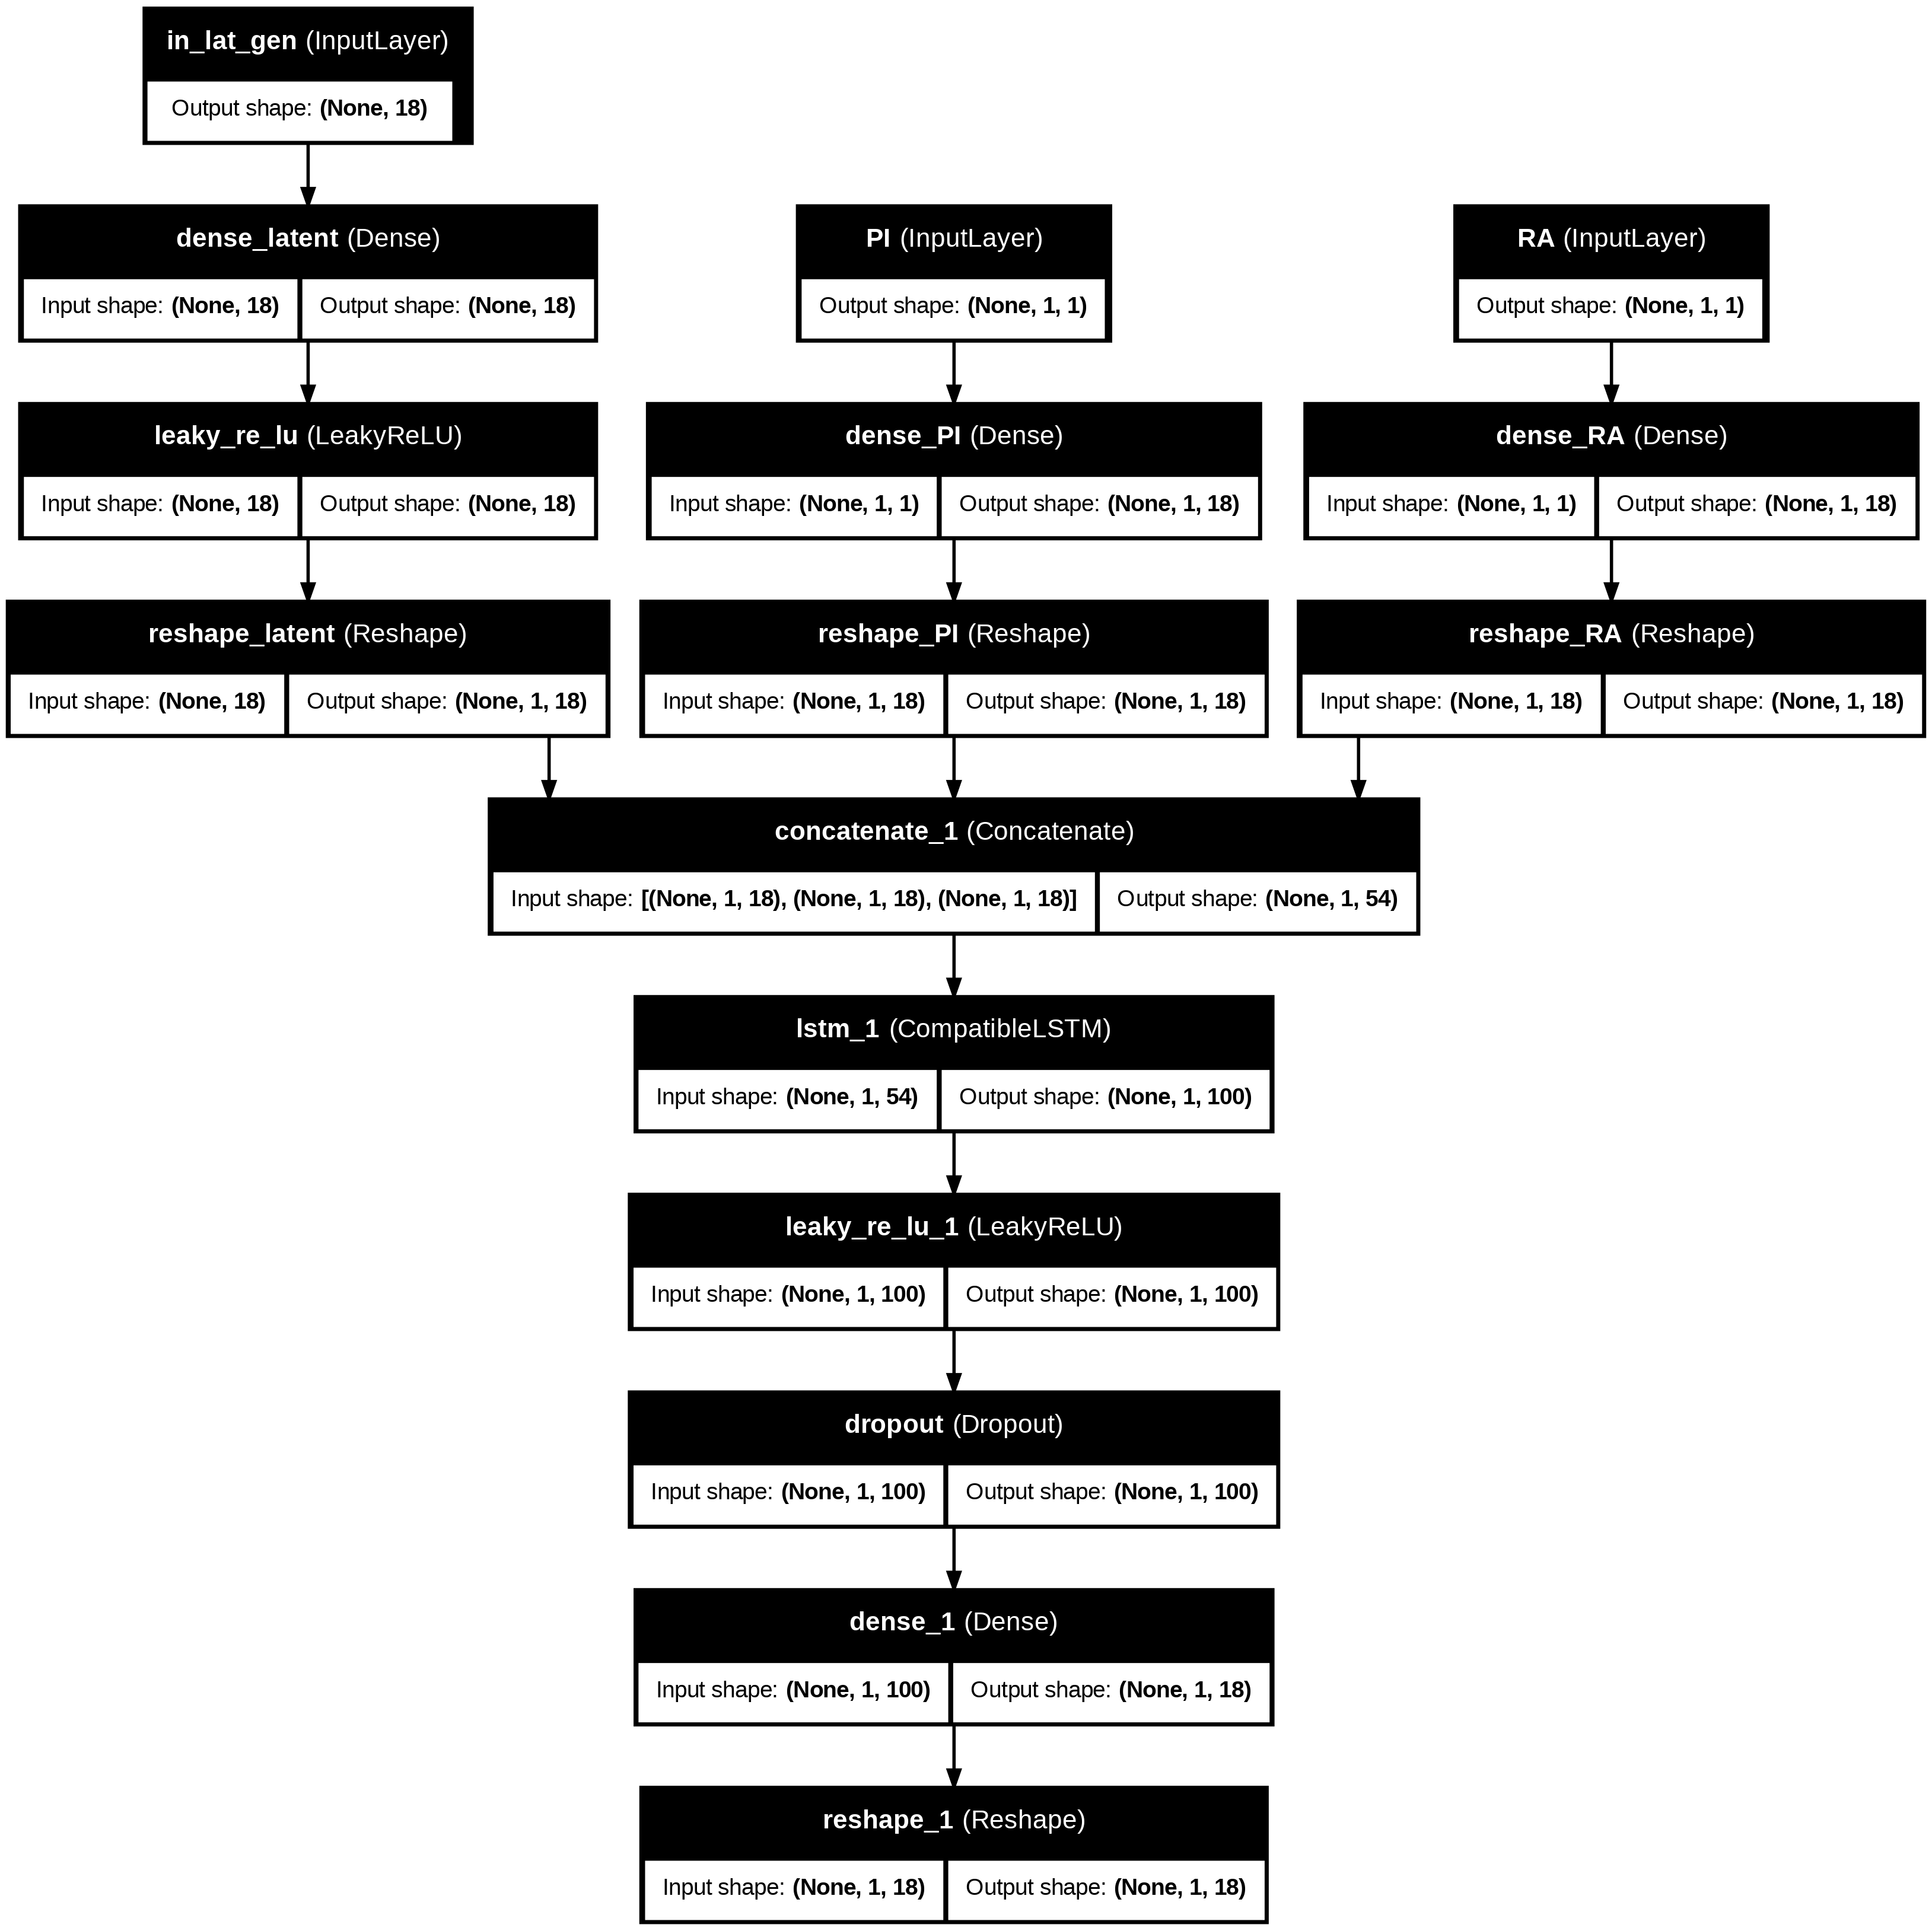

In [11]:
plot_model(pretrained_vae_model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=200)

<h3 style="color:#4FC3F7; border-bottom:2px solid #4FC3F7; padding-bottom:4px;">
2.3 Netron: Interactive Diagram
</h3>

Netron is a tool for visualizing neural network models interactively in your browser. The `netron.start(model_filename)` command launches a web-based viewer, allowing you to explore the model’s architecture, layers, and parameters directly in your browser.


After running the cell, open the provided link.

In [19]:
host, port = netron.start(str(model_filename), browse=False)

url = output.eval_js(f'google.colab.kernel.proxyPort({port})')

IFrame(url, width='100%', height=800)

<h2 style="color:#4FC3F7; border-bottom:2px solid #4FC3F7; padding-bottom:4px;">
3. Load Data
</h2>

In [20]:
path_to_data = "/content/drive/MyDrive/Colab Notebooks/t1d-data-based-digital-twin/data"
path_df = Path(path_to_data, "data_filtered.csv")

df = pd.read_csv(path_df)

display(df.head())

,ID,BG,carbs,bolus,intensity,basal
0,11_0,134.0,0.0,0.00,0,0.029167
1,11_0,125.0,0.0,0.00,0,0.000000
2,11_0,132.0,0.0,0.00,0,0.029167
3,11_0,132.0,0.0,0.00,0,0.029167
4,11_0,132.0,0.0,0.15,0,0.029167


<h2 style="color:#4FC3F7; border-bottom:2px solid #4FC3F7; padding-bottom:4px;">
4. Physiological Approximations
</h2>
In this section, we use physiological models to approximate two key quantities for each patient:  
- **PI (Plasma Insulin):** The effective insulin in the bloodstream, calculated from both bolus and basal insulin delivery using a compartmental model based on the Hovorka equations[\[1\]](#ref1).  
- **RA (Rate of Appearance of Glucose):** The rate at which glucose enters the bloodstream after carbohydrate intake, also modeled using a compartmental approach[\[1\]](#ref1).

These approximations transform raw insulin and carbohydrate data into physiologically meaningful features, which are more suitable for downstream modeling and simulation. The resulting columns, `PI` and `RA`, are added to the patient dataframes and will be used as inputs for the deep learning model in the next steps.

<h3 style="color:#4FC3F7; border-bottom:2px solid #4FC3F7; padding-bottom:4px;">
4.1 Equations
</h3>
Here are the implementations for solving the differential equations in Python functions.

In [21]:
def process_pi(df: pd.DataFrame, params_pi: dict) -> pd.DataFrame:
    """
    Process the 'PI' column of the dataframe using parameters from params_pi.

    Args:
        df (pd.DataFrame): Dataframe to process.
        params_pi (dict): Dictionary containing parameter values.

    Returns:
        pd.DataFrame: Dataframe with processed 'PI' column.
    """

    def system(y0, t, params, u_t_values):
        s1, s2, ifa = y0  # Corrected N806
        vi = params['VI']  # Corrected N806
        ke = params['Ke']  # Corrected N806
        tmaxi = params['tmaxI']  # Corrected N806
        kdia = 1 / tmaxi  # Corrected N806
        dt = params['dt']

        u_t = u_t_values[int(t / dt)] if int(t / dt) < len(u_t_values) else 0  # Corrected SIM108

        ds1 = u_t - kdia * s1  # Corrected N806
        ds2 = kdia * (s1 - s2)  # Corrected N806
        difa = (s2 / (tmaxi * vi)) - ke * ifa  # Corrected N806

        return [ds1, ds2, difa]

    # Fill missing data
    df['bolus'] = df['bolus'].fillna(0)

    bolus_by_id = {}
    # Group by ID and process each group
    for patient_id, group in tqdm(df.groupby('ID'), desc='Processing bolus PI', total=df['ID'].nunique()):  # Corrected N806
        u_t_values = group['bolus'].values / params_pi['dt']
        y0 = [0, 0, 0]  # Initial conditions
        t = np.arange(0, len(group) * params_pi['dt'], params_pi['dt'])  # Time vector

        # Solve ODE for the current group
        sol = odeint(system, y0, t, args=(params_pi, u_t_values), hmax=params_pi['dt'])
        bolus_by_id[patient_id] = sol[:, 2]  # Add solution for Ifa to the group's dataframe

    # Fill missing data
    df['basal'] = df['basal'].fillna(0)

    basal_by_id = {}
    # Group by ID and process each group
    for patient_id, group in tqdm(df.groupby('ID'), desc='Processing basal PI', total=df['ID'].nunique()):  # Corrected N806
        u_t_values = group['basal'].values / params_pi['dt']
        y0 = [0, 0, 0]  # Initial conditions
        t = np.arange(0, len(group) * params_pi['dt'], params_pi['dt'])  # Time vector

        # Solve ODE for the current group
        sol = odeint(system, y0, t, args=(params_pi, u_t_values), hmax=params_pi['dt'])
        basal_by_id[patient_id] = sol[:, 2]  # Add solution for Ifa to the group's dataframe

    for idx in df['ID'].unique():
        # Retrieve the index positions for the current sub_id
        index_positions = df[df['ID'] == idx].index

        # Retrieve the corresponding values from each dictionary
        boluses_values = bolus_by_id.get(idx, [0] * len(index_positions))
        basal_values = basal_by_id.get(idx, [0] * len(index_positions))

        pi_values = [sum(x) for x in zip(boluses_values, basal_values, strict=False)]
        df.loc[index_positions, 'PI'] = pi_values

    return df


def process_ra(df: pd.DataFrame, params_ra: dict) -> pd.DataFrame:
    """
    Process the 'RA' column of the dataframe using parameters from params_ra.

    Args:
        df (pd.DataFrame): Dataframe to process.
        params_ra (dict): Dictionary containing parameter values.

    Returns:
        pd.DataFrame: Dataframe with processed 'RA' column.
    """
    dt = params_ra['dt']  # Extract time step for easier use later

    def system(y0, t, params, u_t_values):
        d1, d2 = y0  # Corrected N806
        tau_d = params['tau_D']  # Corrected N806
        a_g = params['A_G']  # Corrected N806

        u_t = u_t_values[int(t / dt)] if int(t / dt) < len(u_t_values) else 0  # Corrected SIM108

        # Rate equations
        dd1 = a_g * u_t - 1 / tau_d * d1  # Corrected N806
        dd2 = 1 / tau_d * d1 - 1 / tau_d * d2  # Corrected N806

        return [dd1, dd2]

    # Fill missing data
    df['carbs'] = df['carbs'].fillna(0)

    # Group by ID and process each group
    for _, group in tqdm(df.groupby('ID'), desc='Processing RA', total=df['ID'].nunique()):  # Corrected N806, B007
        u_t_values = group['carbs'].values
        y0 = [0, 0]  # Initial conditions for D1 and D2
        t = np.linspace(0, (len(group) - 1) * dt, len(group))  # Time vector

        # Solve ODE for the current group
        sol = odeint(system, y0, t, args=(params_ra, u_t_values), hmax=dt)

        # Compute Ra from D2
        d1, d2 = sol.T  # Corrected N806
        ra = d2 / params_ra['tau_D']  # Corrected N806

        # Store results in the group's dataframe
        group['RA'] = ra
        df.loc[group.index, 'RA'] = group['RA']

    return df

<h3 style="color:#4FC3F7; border-bottom:2px solid #4FC3F7; padding-bottom:4px;">
4.2 Parameters
</h3>

These two dictionaries contain the parameters for the PI and RA physiological models, extracted from [\[1\]](#ref1).
- **params_pi**:  
    Dictionary of parameters for the plasma insulin (PI) physiological model:  
    - `VI`: Insulin distribution volume (L/kg)  
    - `Ke`: Insulin elimination rate constant (1/min)  
    - `tmaxI`: Time-to-maximum insulin absorption (min)  
    - `dt`: Time step for simulation (min)  

- **params_ra**:  
    Dictionary of parameters for the rate of appearance (RA) of glucose model:  
    - `tau_D`: Time constant for glucose absorption (min)  
    - `A_G`: Fraction of carbohydrate absorbed  
    - `dt`: Time step for simulation (min)

In [22]:
params_pi: dict[str, float] = {'VI': 0.12,
                               'Ke': 0.138,
                               'tmaxI': 55,
                               'dt': 5,
                               }
params_ra: dict[str, float] = {'tau_D': 40,
                               'A_G': 0.8,
                               'dt': 5
                               }

<h3 style="color:#4FC3F7; border-bottom:2px solid #4FC3F7; padding-bottom:4px;">
4.3 Let's solve
</h3>

In [23]:
df = process_pi(df, params_pi)

df = process_ra(df, params_ra)

Processing RA: 100%|██████████| 2/2 [00:00<00:00, 24.28it/s]


<h3 style="color:#4FC3F7; border-bottom:2px solid #4FC3F7; padding-bottom:4px;">
4.4 Plotting the Solved Equations
</h3>
Here we can see the original discrete signals (bolus and basal, and carbohydrate intake) plotted againsts the solved equations, which result in a continuus curve.

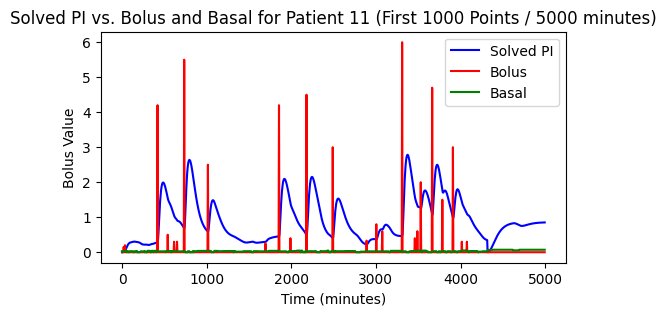

In [24]:
length = 1000
length = min(length, len(df))
df_sliced = df.iloc[:length]
df_sliced = df.iloc[:length]

plt.figure(figsize=(6, 3))
plt.plot(
    df_sliced.index * 5,
    df_sliced['PI'],
    label='Solved PI',
    color='blue',
)
plt.plot(df_sliced.index * 5, df_sliced['bolus'], label='Bolus', color='red')
plt.plot(df_sliced.index * 5, df_sliced['basal'], label='Basal', color='green')

plt.xlabel('Time (minutes)')
plt.ylabel('Bolus Value')
plt.title(f'Solved PI vs. Bolus and Basal for Patient 11 (First {length} Points / {length*5} minutes)')
plt.legend(loc='best')
plt.show()

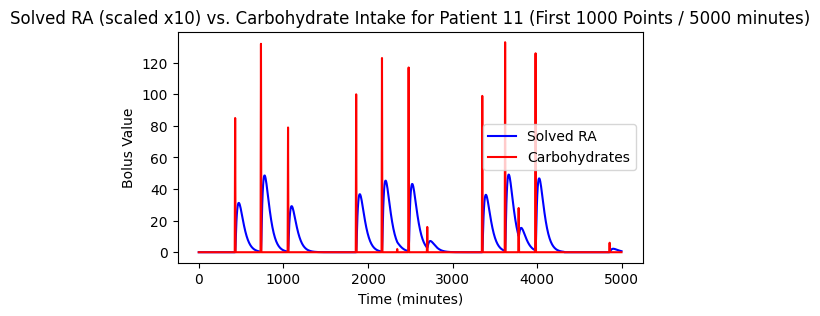

In [25]:
length = 1000
length = min(length, len(df))
df_sliced = df.iloc[:length]
df_sliced = df.iloc[:length]

plt.figure(figsize=(6, 3))
plt.plot(
    df_sliced.index * 5,
    df_sliced['RA']*10,
    label='Solved RA',
    color='blue',
)
plt.plot(df_sliced.index * 5, df_sliced['carbs'], label='Carbohydrates', color='red')

plt.xlabel('Time (minutes)')
plt.ylabel('Bolus Value')
plt.title(f'Solved RA (scaled x10) vs. Carbohydrate Intake for Patient 11 (First {length} Points / {length*5} minutes)')
plt.legend(loc='best')
plt.show()

For visualization purposes we have upscaled the solved RA vector.

<h2 style="color:#4FC3F7; border-bottom:2px solid #4FC3F7; padding-bottom:4px;">
5. Save Processed Data for Modeling
</h2>

In [27]:
columns_to_save = ['ID', 'BG', 'PI', 'RA']
display(df[columns_to_save])
path_to_processed_data = "/content/drive/MyDrive/Colab Notebooks/t1d-data-based-digital-twin/data/"
df[columns_to_save].to_csv(path_to_processed_data + 'data_processed.csv', index=False)

,ID,BG,PI,RA
0,11_0,134.0,0.000000,0.000000
1,11_0,125.0,0.000271,0.000000
2,11_0,132.0,0.001510,0.000000
3,11_0,132.0,0.003488,0.000000
4,11_0,132.0,0.006741,0.000000
...,...,...,...,...
1723,290_0,70.0,1.402729,0.052132
1724,290_0,69.0,1.373106,0.047064
1725,290_0,69.0,1.344499,0.042466
1726,290_0,69.0,1.316954,0.038300


<h2 style="color:#4FC3F7; border-bottom:2px solid #4FC3F7; padding-bottom:4px;">
References
</h2>
<a id="ref1"></a> [1] Hovorka R, Canonico V, Chassin LJ, Haueter U, Massi-Benedetti M, Orsini Federici M, *et al.* (2004). Nonlinear model predictive control of glucose concentration in subjects with type 1 diabetes. *Physiological Measurement*, 25(4), 905–920.